In [2]:
TEST_PATH = '/Users/h1de0us/uni/mer-eeg-analysis/data/deap_filtered/sub-01/eeg/sub-01_task-run1_eeg.edf'

In [1]:
# !pip install -r ../requirements.txt

In [34]:
!pip install -q ipyevents
!pip install -q ipywidgets
!pip install -q qtpy
!pip install -q pyvista
!pip install pyvistaqt


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
  Using cached pyvistaqt-0.11.0-py3-none-any.whl (131 kB)

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from src.graph import EEGConnectivityGraph

eeg_graph = EEGConnectivityGraph(TEST_PATH)

Extracting EDF parameters from /Users/h1de0us/uni/mer-eeg-analysis/data/deap_filtered/sub-01/eeg/sub-01_task-run1_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/Users/h1de0us/uni/mer-eeg-analysis/connectivity/src/graph.py:13: RuntimeWarning: Invalid date encountered (2014-00-00 00:00:00).
  class EEGConnectivityGraph:


Data shape: (19, 304000)


Extracting EDF parameters from /Users/h1de0us/uni/mer-eeg-analysis/data/deap_filtered/sub-01/eeg/sub-01_task-run1_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Data shape: (19, 304000)


/Users/h1de0us/uni/mer-eeg-analysis/connectivity/src/graph.py:11: RuntimeWarning: Invalid date encountered (2014-00-00 00:00:00).
  self.raw = mne.io.read_raw_edf(eeg_data_path)


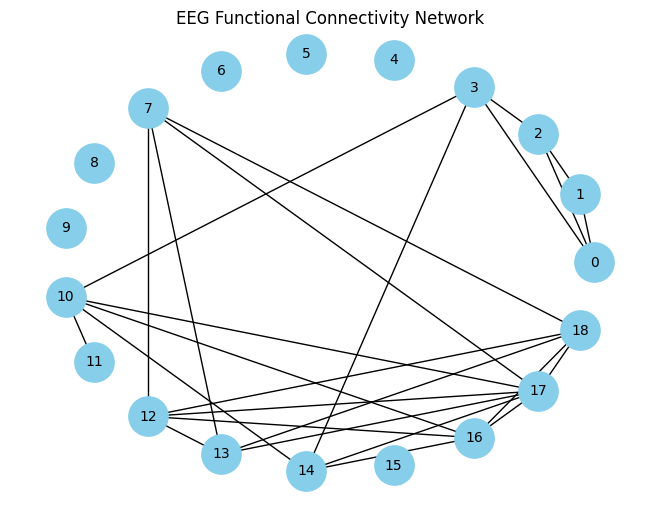

In [6]:
# Compute correlation-based connectivity and visualize as a graph
correlation_matrix = eeg_graph.compute_connectivity(method='correlation', threshold=0.6)
eeg_graph.create_graph(correlation_matrix)

### Coherence estimation

In [25]:
# Compute coherence-based connectivity and visualize as a graph
con = eeg_graph.compute_connectivity(method='coh', fmin=12, fmax=100)
con

Loading data for 1215 events and 500 original time points ...


Epochs shape: (1215, 19, 500)


<SpectralConnectivity | freq : [56.000000, 56.000000], , nave : 1215, nodes, n_estimated : 19, 361, ~50 kB>

In [26]:
# the dimensions of the data corresponding to each axis
print(con.dims)

# the coordinates for each axis of the data
print(con.coords)

# the number of nodes matches the number of electrodes used to compute the
# spectral measure
print(con.n_nodes)

# the names of each node correspond to the electrode names
print(con.names)

('node_in -> node_out', 'freqs')
Coordinates:
  * node_in -> node_out  (node_in -> node_out) <U3 4kB '0' '1' ... '359' '360'
  * freqs                (freqs) float64 8B 56.0
19
['FP1', 'FP2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']


In [27]:
# the underlying data is stored "raveled", and the connectivity measure is flattened into one dimension
print(con.shape)

# the 'dense' output will show the connectivity measure's N x N axis
print(con.get_data(output="dense").shape)

(361, 1)
(19, 19, 1)


In [28]:
from mne_connectivity.viz import plot_sensors_connectivity

epochs = eeg_graph.compute_epochs()
con_data = con.get_data(output="dense")[:, :, 0]
con_data.shape

(19, 19)

In [29]:
import numpy as np

# Get the strongest n_con connections
threshold = np.sort(con_data, axis=None)[-20]
ii, jj = np.where(con_data >= threshold)
len(ii), len(jj)

(20, 20)

In [30]:
info = epochs.info
info["chs"][0]

{'cal': 1.0,
 'logno': 1,
 'scanno': 1,
 'range': 1.0,
 'unit_mul': 0 (FIFF_UNITM_NONE),
 'ch_name': 'FP1',
 'unit': 107 (FIFF_UNIT_V),
 'coord_frame': 4 (FIFFV_COORD_HEAD),
 'coil_type': 1 (FIFFV_COIL_EEG),
 'kind': 2 (FIFFV_EEG_CH),
 'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])}

In [22]:
# no 3d plot because no information about the sensor locations
# plot_sensors_connectivity(epochs.info, con_data, con.names, cbar_label='Coherence', n_con=20)

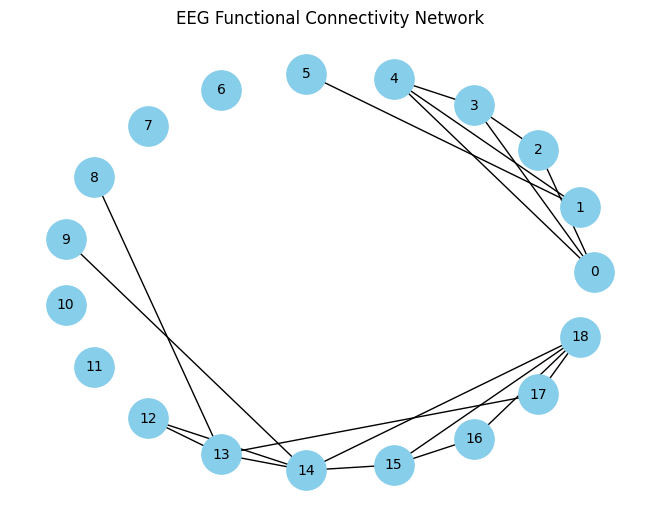

In [33]:
con_data = con_data > threshold
eeg_graph.create_graph(con_data)

### PLV estimation

In [34]:
con = eeg_graph.compute_connectivity(method='plv', fmin=12, fmax=100)
con

Loading data for 1215 events and 500 original time points ...


Epochs shape: (1215, 19, 500)


<SpectralConnectivity | freq : [56.000000, 56.000000], , nave : 1215, nodes, n_estimated : 19, 361, ~50 kB>

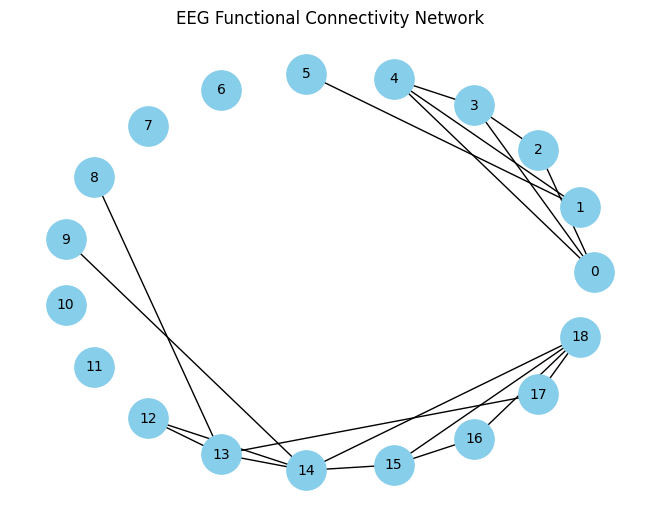

In [35]:
con_data = con.get_data(output="dense")[:, :, 0]

threshold = np.sort(con_data, axis=None)[-20]
ii, jj = np.where(con_data >= threshold)
len(ii), len(jj)

con_data = con_data > threshold
eeg_graph.create_graph(con_data)

### PLI estimation

In [36]:
con = eeg_graph.compute_connectivity(method='pli', fmin=12, fmax=100)
con

Loading data for 1215 events and 500 original time points ...


Epochs shape: (1215, 19, 500)


<SpectralConnectivity | freq : [56.000000, 56.000000], , nave : 1215, nodes, n_estimated : 19, 361, ~50 kB>

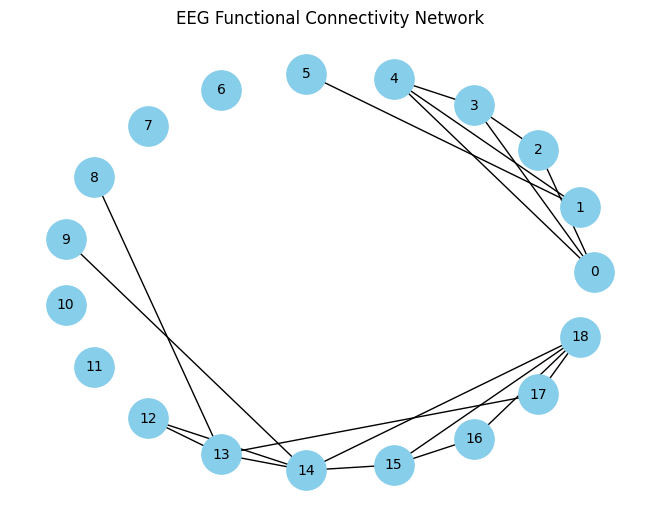

In [37]:
con_data = con.get_data(output="dense")[:, :, 0]

threshold = np.sort(con_data, axis=None)[-20]
ii, jj = np.where(con_data >= threshold)
len(ii), len(jj)

con_data = con_data > threshold
eeg_graph.create_graph(con_data)


(имеет смысл, что совпали когерентность и PLV)